# Power Operations Data from the EIA's API
This notebook presents a simple demonstration of pulling in data from the Energy Information Administration's (EIA's) API. We will pull some power operations data, convert it to a dataframe, and create some simple plots.

## 1. Paste in an EIA API Key
A key is required to access data through the EIA API, and instructions on registering for a key are available on the 
<a href="https://www.eia.gov/opendata/">EIA Open Data webpage</a>. This notbook won't run unless a valid key has been pasted into the spot below:

In [23]:
# paste in your key from EIA with quotation marks
key = ''

In [16]:
# import libraries needed
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt

## 2. Make the API GET Request
We set up our parameters for the GET request. In this example, we are looking at RTO hourly power operations data for MISO during June to August 2023.

In [107]:
# set up and make API GET request
baseurl='https://api.eia.gov/v2/electricity/rto/region-data/data/'
api_params = {'frequency':'hourly','data[0]':'value',
              'facets[respondent][]':'NYIS',
              'facets[type][]':['D','DF'],
              'start':'2023-06-01T00',
              'end':'2023-08-31T00','sort[0][column]':'period',
              'sort[0][direction]':'asc','offset':'0','length':'5000'}
api_params['api_key'] = key
# make request
r = requests.get(baseurl,params=api_params,timeout=20)
print(r.status_code) # make sure request is ok- should return 200

200


## 3. Clean up Data
We convert the results to a dataframe and clean up the data. 

In [108]:
# convert results to a dataframe
results = json.loads(r.text) # convert to dict
pwr_df = pd.DataFrame(results["response"]["data"])
pwr_df.info() # check columns and data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4370 entries, 0 to 4369
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   period           4370 non-null   object
 1   respondent       4370 non-null   object
 2   respondent-name  4370 non-null   object
 3   type             4370 non-null   object
 4   type-name        4370 non-null   object
 5   value            4370 non-null   object
 6   value-units      4370 non-null   object
dtypes: object(7)
memory usage: 239.1+ KB


In [109]:
# clean up dataset
pwr_df = pwr_df[['period','type-name','value']] # select desired columns
pwr_df[['type-name']] = pwr_df[['type-name']].astype(str) #convert to string
pwr_df = pwr_df[pwr_df['type-name'].isin(['Day-ahead demand forecast','Demand'] )] #filter on demand columns
pwr_df['period'] = pd.to_datetime(pwr_df['period'],utc=True) #make datetime
pwr_df['value'] = pd.to_numeric(pwr_df['value']) #make numeric
pwr_df.reset_index(drop=True, inplace=True)
pwr_df = pd.pivot(pwr_df,index='period',columns='type-name',values='value').reset_index()
#pwr_df.reset_index(drop=True, inplace=True)
pwr_df = pwr_df.rename(columns={'period':'DateTime','Day-ahead demand forecast':'ForecastLoad','Demand':'ActualLoad'})
pwr_df = pwr_df.reset_index(drop=True)
pwr_df.sort_values(by=['DateTime'], ascending=False)
pwr_df.head()

type-name,DateTime,ForecastLoad,ActualLoad
0,2023-06-01 00:00:00+00:00,18786,19615
1,2023-06-01 01:00:00+00:00,18328,19190
2,2023-06-01 02:00:00+00:00,17816,18478
3,2023-06-01 03:00:00+00:00,16644,17133
4,2023-06-01 04:00:00+00:00,15394,15762


In [103]:
# review the data
pwr_df.describe()

type-name,ForecastLoad,ActualLoad
count,2185.000000,2185.000000
mean,6307.311213,6288.865904
std,845.874766,855.365060
min,4601.000000,4679.000000
25%,5596.000000,5562.000000
50%,6305.000000,6296.000000
75%,6909.000000,6870.000000
max,9151.000000,9075.000000


## 4. Create Plots

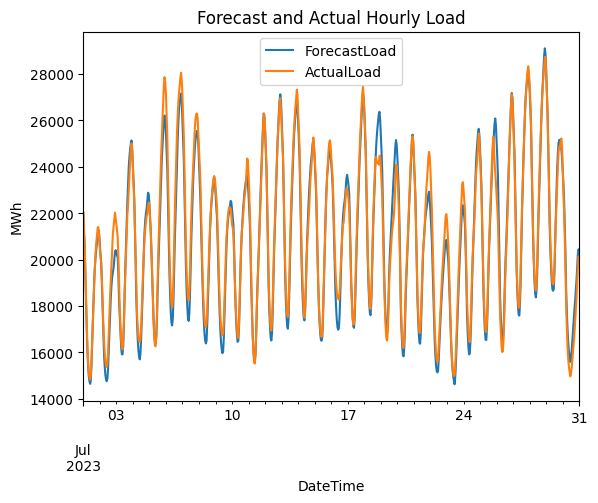

In [110]:
# plot forecast and actual for select date range
start_time = '2023-7-01 00:00:00+00:00'
end_time = '2023-7-31 00:00:00+00:00'

mydf = pwr_df.loc[(pwr_df['DateTime'] >= start_time) & (pwr_df['DateTime'] <= end_time)]
fig1 = mydf.plot(x="DateTime",y=['ForecastLoad','ActualLoad'], kind='line',)
fig1.legend()
plt.ylabel('MWh')
plt.title('Forecast and Actual Hourly Load')
plt.show(fig1)

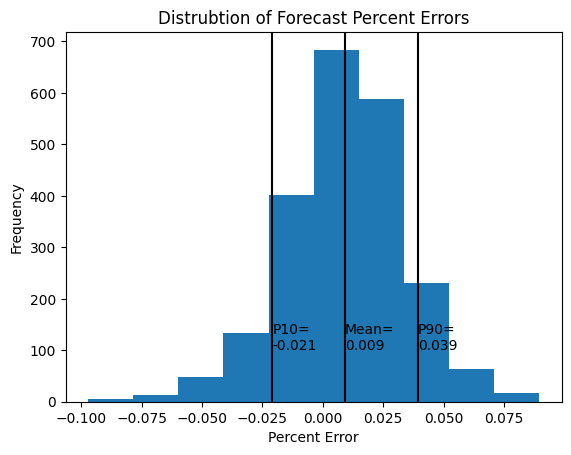

In [149]:
# create historgram of forecast percent error
pwr_df['ErrorPct'] = (pwr_df['ActualLoad'] / pwr_df['ForecastLoad']) - 1
pwr_df['ErrorPct'].describe()
fig2 = pwr_df.plot(column=['ErrorPct'], kind='hist',legend=False,
                  title='Distrubtion of Forecast Percent Errors',
                  xlabel='Percent Error')
mean_pct_error = pwr_df['ErrorPct'].mean()
pct_error_ptcl10 = pwr_df['ErrorPct'].quantile(0.1)
pct_error_ptcl90 = pwr_df['ErrorPct'].quantile(0.9)
plt.axvline(x=mean_pct_error,color='black')
plt.axvline(x=pct_error_ptcl10,color='black')
plt.axvline(x=pct_error_ptcl90,color='black')
plt.text(mean_pct_error,100,'Mean=\n'+str(round(mean_pct_error,3)))
plt.text(pct_error_ptcl10,100,'P10=\n'+str(round(pct_error_ptcl10,3)))
plt.text(pct_error_ptcl90,100,'P90=\n'+str(round(pct_error_ptcl90,3)))
plt.show(fig2)

Text(0, 0.5, 'Percent Error')

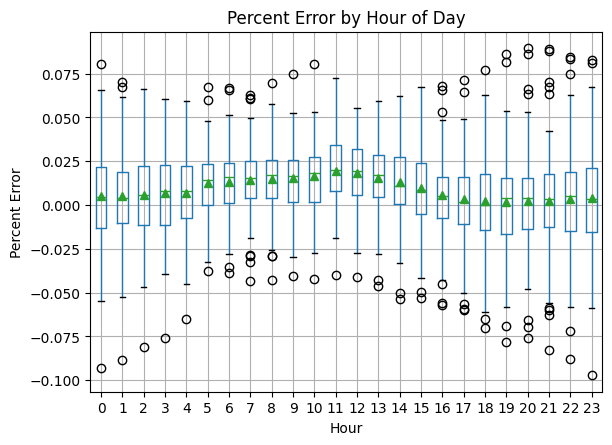

In [113]:
# plot forecast error by hour of day
pwr_df['Hour'] = pwr_df['DateTime'].dt.hour
fig3 = pwr_df.boxplot(column=['ErrorPct'], by='Hour', showmeans=True)
fig3.get_figure().suptitle('')
fig3.set_title('Percent Error by Hour of Day')
fig3.set_ylabel('Percent Error')